<a href="https://colab.research.google.com/github/ldaniel/Advanced-Predictive-Analytics/blob/master/Autoencoder_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D
from scipy.spatial.distance import cdist

%matplotlib inline

In [0]:
#@title
def plot_random_batch(batch, y_true, y_pred=None, batch_size=30, n_cols=10, figsize=(20, 10)):
    plt.figure(figsize=figsize)

    random_idx = np.random.choice(batch.shape[0], size=batch_size)
    x_batch = batch[random_idx].squeeze()
    y_batch = y_true[random_idx]
    
    y_pred = y_batch if y_pred is None else y_pred[random_idx]
    n_rows = x_batch.shape[0] // n_cols + 1
    is_gray = (batch.shape[-1] == 1) or (len(batch.shape) == 3)
    for img, true, pred, sub in zip(x_batch, y_batch, y_pred, range(1, len(batch)+1)):
        plt.subplot(n_rows, n_cols, sub)
        plt.imshow(img.astype(np.uint8), cmap='gray' if is_gray else None)
        
        plt.title("T:{} P:{}".format(true, pred), color = 'green' if true == pred else 'red')
        plt.axis('off')
    plt.tight_layout()

def plot_history(history, figsize=(12, 4), loss_train_key='loss', loss_val_key='val_loss', metric_train_key='accuracy', metric_val_key='val_accuracy'):
    loss_train = history.get(loss_train_key, [])
    loss_valid = history.get(loss_val_key, [])
    metric_train = history.get(metric_train_key, [])
    metric_valid = history.get(metric_val_key, [])

    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.plot(loss_train, label='train')
    plt.plot(loss_valid, label='val')
    plt.ylim(0)
    plt.legend()

    if len(metric_train) > 0 or len(metric_valid) > 0:
        plt.subplot(1, 2, 2)
        plt.plot(metric_train, label='train')
        plt.plot(metric_valid, label='val')
        plt.ylim(top=1)
        plt.legend()

# Data Loading

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.expand_dims(x_train, axis=-1) / 255
x_test = np.expand_dims(x_test, axis=-1) / 255

print(x_train.shape, x_train.dtype)
print(x_test.shape, x_test.dtype)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28, 1) float64
(10000, 28, 28, 1) float64


# Autoencoder

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
enc_1 (Conv2D)               (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
enc_2 (Conv2D)               (None, 14, 14, 8)         1160      
_________________________________________________________________
encoded (MaxPooling2D)       (None, 7, 7, 8)           0         
_________________________________________________________________
dec_1 (Conv2D)               (None, 7, 7, 8)           584       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 8)         0         
_________________________________________________________________
dec_2 (Conv2D)               (None, 14, 14, 16)        1

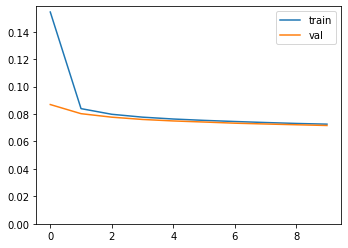

In [0]:
model = Sequential([
    # encoder
    Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', name='enc_1', input_shape=(28, 28, 1)),
    MaxPool2D(pool_size=(2, 2), padding='valid'),
    Conv2D(filters=8, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', name='enc_2'),
    MaxPool2D(pool_size=(2, 2), padding='valid', name='encoded'),

    # decoder
    Conv2D(filters=8, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', name='dec_1'),
    UpSampling2D(size=(2, 2)),
    Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', name='dec_2'),
    UpSampling2D(size=(2, 2)),
    Conv2D(filters=1, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='sigmoid', name='decoded')
])
model.summary()

# binary cross entropy pra tentar acertar a classe do pixel
model.compile(optimizer='adam', loss='binary_crossentropy')

# batch=128 pra treinar mais rápido
hist = model.fit(x_train, x_train, batch_size=128, epochs=10, verbose=1, validation_data=(x_test, x_test))

plot_history(hist.history)

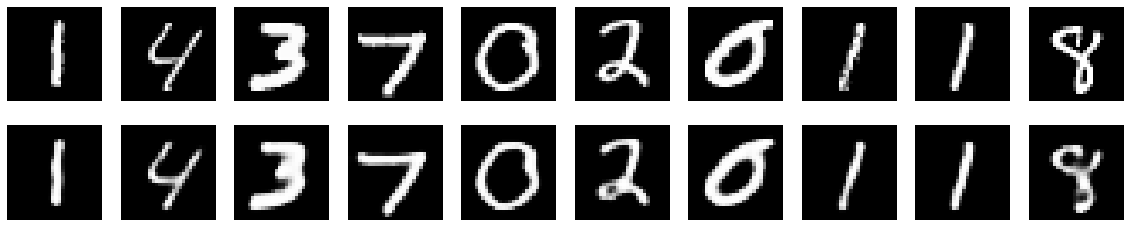

In [0]:
n_imgs = 10

random_idxs = np.random.choice(range(x_test.shape[0]), size=n_imgs)
im_ori = x_test[random_idxs]
im_dec = model.predict(im_ori)

plt.figure(figsize=(20, 4))
for i in range(n_imgs):
    plt.subplot(2, n_imgs, i + 1)
    plt.imshow(im_ori[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

    plt.subplot(2, n_imgs, i + 1 + n_imgs)
    plt.imshow(im_dec[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

# Sistema de Recomendação

In [0]:
encoder = Model(inputs=model.input, outputs=model.get_layer(name='encoded').output)
x_test_enc = encoder.predict(x_test)
x_test_enc.shape

(10000, 7, 7, 8)

In [0]:
embeddings = x_test_enc.reshape(x_test_enc.shape[0], -1)
embeddings.shape

(10000, 392)

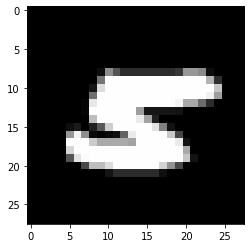

In [0]:
random_idx = np.random.choice(range(x_test.shape[0]), size=1)
im_ref = x_test[random_idx]
emb_ref = embeddings[random_idx]

plt.imshow(im_ref.squeeze(), cmap='gray')

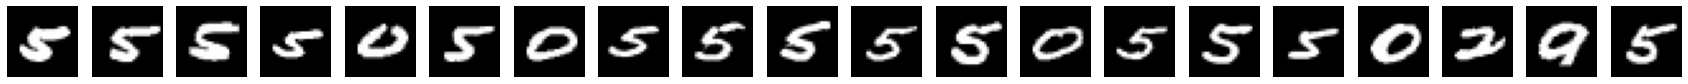

In [0]:
n_imgs = 20

distances = cdist(emb_ref, embeddings).squeeze()
closest_idxs = np.argsort(distances)[1:n_imgs+1] # from 1 because the img in 0 is the reference image itself

im_ori = x_test[closest_idxs]

plt.figure(figsize=(30, 4))
for i in range(n_imgs):
    plt.subplot(2, n_imgs, i + 1)
    plt.imshow(im_ori[i].reshape(28, 28), cmap='gray')
    plt.axis('off')